In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import MySQLdb

import matplotlib.transforms as transforms
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7.0, 5.5)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelcolor'] = "#000000"

In [2]:
db = MySQLdb.connect(db="decam_rescaled", read_default_file="~/.my.cnf")
cursor = db.cursor()

In [3]:
cursor.execute("SELECT visitid, templateVisitId, AVG(coord_ra), AVG(coord_dec), "
               "COUNT(DISTINCT ccdnum), count(visitid), sum(classification_dipole) "
               "FROM diasource GROUP BY visitid;")
rows = cursor.fetchall()

In [4]:
counts_table = Table(rows=rows, names=("visit", "templateVisit", "field_ra", "field_dec",
                                       "ccd_count", "source_count", "dipole_count"))
counts_table

visit,templateVisit,field_ra,field_dec,ccd_count,source_count,dipole_count
int64,int64,float64,float64,int64,int64,float64
197367,197371,189.937742935,-6.39077592546,59,24001,2853.0
197375,197371,190.111006427,-6.41447481921,59,25912,2580.0
197379,197371,189.918082994,-6.36711332593,59,23472,2460.0
197388,197384,197.062628782,-16.6190572278,59,35105,3299.0
197392,197384,197.146580082,-16.5700563672,59,38447,3371.0
197400,197408,199.982466848,-18.4134704114,59,21991,3447.0
197404,197408,199.97205883,-18.4072704335,59,25129,3667.0
197412,197408,199.93835754,-18.4571707976,43,16385,2694.0
197802,197790,81.5677659226,-8.6962142785,7,99350,1295.0


In [5]:
cursor.execute("SELECT visitid, fs.base_psfFlux_flux,  "
               "fs.template_base_PsfFlux_flux/fs.template_base_PsfFlux_fluxSigma as template_SNR, "
               "fs.base_PsfFlux_flux/fs.base_PsfFlux_fluxSigma as science_SNR, "
               "dia.base_PsfFlux_flux/dia.base_PsfFlux_fluxSigma as detection_SNR, "
               "(fs.base_PsfFlux_flux - fs.template_base_PsfFlux_flux) as corr_flux, "
               "SQRT(POW(fs.base_PsfFlux_fluxSigma,2) + POW(fs.template_base_PsfFlux_fluxSigma,2)) as corr_sigma "
               #"corr_flux/corr_Sigma as corr_SNR "
               "FROM diasource as dia "
               "JOIN force_source as fs ON id=objectId "
               "WHERE visitid=197367 AND dia.classification_dipole=0")
rows = cursor.fetchall()
snr_table = Table(rows=rows, names=("visit", "dia_flux", "template_SNR", "science_SNR",
                                       "detection_SNR", "corr_flux", "corr_sigma"))

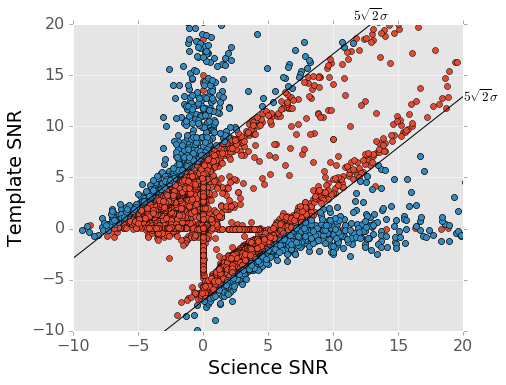

In [6]:
corr_SNR = np.abs(snr_table["corr_flux"])/snr_table["corr_sigma"]
sel,= np.where(corr_SNR > 5)
plt.plot(snr_table["science_SNR"], snr_table["template_SNR"], 'o')
plt.plot(snr_table["science_SNR"][sel], snr_table["template_SNR"][sel], 'o')
plt.xlim(-10,20)
plt.ylim(-10,20)
x = np.linspace(-10,20)
#plt.plot(x, x+5, 'k-')
#plt.plot(x, x-5, 'k-')
plt.plot(x, x+5*np.sqrt(2), 'k-')
plt.plot(x, x-5*np.sqrt(2), 'k-')
plt.xlabel("Science SNR")
plt.ylabel("Template SNR")
plt.text(20,20-5*np.sqrt(2), r"$5\sqrt{2}\sigma$", fontsize="small",
        verticalalignment="center")
plt.text(20-5*np.sqrt(2), 20, r"$5\sqrt{2}\sigma$", fontsize="small",
         verticalalignment="bottom", horizontalalignment="center")

In [7]:
positive_noise = sum((corr_SNR > 5)
                     & (np.abs(snr_table["science_SNR"]) < 5*np.sqrt(2)) &
                     (snr_table["science_SNR"] > snr_table["template_SNR"]))
negative_noise = sum((corr_SNR > 5) & (np.abs(snr_table["template_SNR"]) < 5*np.sqrt(2))
                     & (snr_table["science_SNR"] < snr_table["template_SNR"]))
print "Positive noise", positive_noise
print "Negative noise", negative_noise

Positive noise 279
Negative noise 287


In [8]:
area = 0.043*59
print "Positive sources", sum(snr_table["detection_SNR"] > 0), sum(snr_table["detection_SNR"] > 0)/area
print "Negative sources", sum(snr_table["detection_SNR"] < 0), sum(snr_table["detection_SNR"] < 0)/area

# Here we use 5 sigma, not 5sqrt(2), since corr_sigma already has the sqrt(2) built in.
pos_postfilter = sum(snr_table["corr_flux"]/snr_table["corr_sigma"] > 5)
neg_postfilter = sum(snr_table["corr_flux"]/snr_table["corr_sigma"] < -5)
print "Positive after force-phot filter", pos_postfilter, pos_postfilter/area
print "Negative after force-phot filter", neg_postfilter, neg_postfilter/area

print len(sel), len(corr_SNR) 

Positive sources 9062 3571.93535672
Negative sources 12086 4763.89436342
Positive after force-phot filter 1220 480.882932598
Negative after force-phot filter 1408 554.986204178
2628 21148


In [9]:
cursor.execute("SELECT visitid, COUNT(DISTINCT ccdnum), AVG(dia.coord_ra), AVG(dia.coord_dec), "
               "SUM(dia.base_PsfFlux_flux > 5), "
               "SUM(dia.base_PsfFlux_flux < -5), "               
               "SUM((fs.base_PsfFlux_flux - fs.template_base_PsfFlux_flux)/"
               "SQRT(POW(fs.base_PsfFlux_fluxSigma,2) + POW(fs.template_base_PsfFlux_fluxSigma,2)) > 5), "
               "SUM((fs.base_PsfFlux_flux - fs.template_base_PsfFlux_flux)/"
               "SQRT(POW(fs.base_PsfFlux_fluxSigma,2) + POW(fs.template_base_PsfFlux_fluxSigma,2)) < -5) "
               "FROM diasource as dia "
               "JOIN force_source as fs ON id=objectId "
               "WHERE dia.classification_dipole=0 "
               "GROUP BY visitid")

rows = cursor.fetchall()
counts_table = Table(rows=rows, names=("visitid", "ccds", "field_ra", "field_dec",
                                       "raw_pos_counts", "raw_neg_counts",
                                       "filtered_pos", "filtered_neg"))
counts_table

visitid,ccds,field_ra,field_dec,raw_pos_counts,raw_neg_counts,filtered_pos,filtered_neg
int64,int64,float64,float64,object,object,object,object
197367,59,189.942216541,-6.38801360089,9053,11548,1220,1408
197375,59,190.135770189,-6.41689378862,6973,15869,1346,1446
197379,59,189.919174679,-6.3649007075,11665,9072,1859,1163
197388,59,197.090888006,-16.625411278,10706,20575,1910,1286
197392,59,197.178848946,-16.5710622951,13819,20669,2251,1397
197400,59,199.979065842,-18.4150945623,8900,9300,2033,1991
197404,58,199.962241114,-18.4083155717,11878,9075,2537,994
197412,43,199.929457452,-18.4679441638,6191,7072,2109,1263
197802,7,81.5682165385,-8.69584205288,26894,70103,46,404


In [10]:
def shade_fields(ra_arr, dec_arr, **kwargs):
    last_ra, last_dec = ra_arr[0], dec_arr[0]
    last_n = 0
    # For alternating between shaded and unshaded regions.
    use_color = True
    y_ax_transform = transforms.blended_transform_factory(plt.gca().transData, plt.gca().transAxes)
    
    for n, (ra, dec) in enumerate(zip(ra_arr, dec_arr)):
        dist = np.sqrt((ra - last_ra)**2 + (dec - last_dec)**2)
        if  dist > 3:
            if use_color:
                plt.fill_between([last_n-0.5+1,n+0.5], [0,0], [1,1], transform=y_ax_transform, **kwargs)
                use_color = False
            else:
                use_color = True

            last_n = n
            last_ra = ra
            last_dec = dec

    if use_color:
        plt.fill_between([last_n-0.5+1,n+1+0.5], [0,0], [1,1], transform=y_ax_transform, **kwargs)


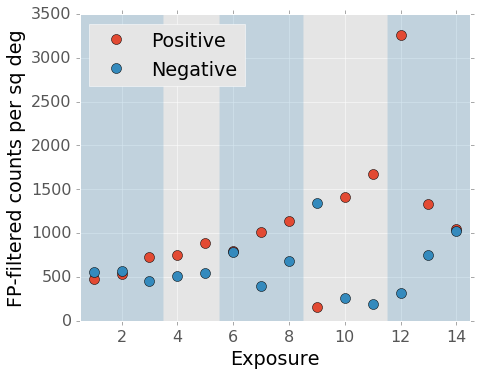

In [11]:
#plt.figure(figsize=(14,5.5))
#plt.subplot(1,2,1)

plt.plot(np.arange(len(counts_table))+1,
         counts_table['filtered_pos'].astype(float)/counts_table['ccds']/0.043, 'o', label="Positive", ms=10)
plt.plot(np.arange(len(counts_table))+1,
         counts_table['filtered_neg'].astype(float)/counts_table['ccds']/0.043, 'o', label="Negative", ms=10)
plt.ylabel("FP-filtered counts per sq deg")
plt.xlabel("Exposure")
plt.legend(loc=0, numpoints=1)
shade_fields(counts_table['field_ra'], counts_table['field_dec'], alpha=0.2)
plt.xlim(0.5,len(counts_table) - 0.5)

if False:
    plt.subplot(1,2,2)
    plt.plot(np.arange(len(counts_table))+1, counts_table['filtered_pos']/counts_table['raw_pos_counts'],
             'o', label="Positive", ms=10)
    plt.plot(np.arange(len(counts_table))+1, counts_table['filtered_neg']/counts_table['raw_neg_counts'],
             'o', label="Negative", ms=10)
    plt.ylabel("Filtered / Raw counts")
    plt.xlabel("Exposure")
    plt.subplots_adjust(wspace=0.25)
#plt.legend(loc=0, numpoints=1)

(0.5, 14.5)

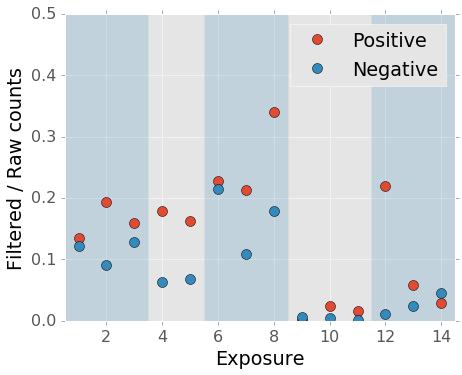

In [12]:
plt.plot(np.arange(len(counts_table))+1, counts_table['filtered_pos']/counts_table['raw_pos_counts'],
         'o', label="Positive", ms=10)
plt.plot(np.arange(len(counts_table))+1, counts_table['filtered_neg']/counts_table['raw_neg_counts'],
         'o', label="Negative", ms=10)
plt.ylabel("Filtered / Raw counts")
plt.xlabel("Exposure")
shade_fields(counts_table['field_ra'], counts_table['field_dec'], alpha=0.2)
plt.legend(loc=0, numpoints=1)
plt.ylim(0,0.5)
plt.xlim(0.5,len(counts_table) - 0.5)